In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.utils import shuffle
%matplotlib inline
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Bidirectional,Activation,Lambda,Input,Embedding,LSTM

In [2]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"siddharthn18","key":"528bbee940517d5161cfb3c279e42e1d"}'}

In [3]:
!pip install -q kaggle
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/root/.kaggle"


In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/


In [5]:
!kaggle datasets download -d vaibhavkumar11/hindi-english-parallel-corpus


Dataset URL: https://www.kaggle.com/datasets/vaibhavkumar11/hindi-english-parallel-corpus
License(s): unknown
 85% 96.0M/112M [00:00<00:00, 993MB/s]
100% 112M/112M [00:00<00:00, 581MB/s] 


In [6]:
!unzip hindi-english-parallel-corpus.zip -d /content/


Archive:  hindi-english-parallel-corpus.zip
  inflating: /content/hindi_english_parallel.csv  


In [7]:
df=pd.read_csv('hindi_english_parallel.csv')
print(df.head())

                                               hindi  \
0    अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें   
1                    एक्सेर्साइसर पहुंचनीयता अन्वेषक   
2              निचले पटल के लिए डिफोल्ट प्लग-इन खाका   
3               ऊपरी पटल के लिए डिफोल्ट प्लग-इन खाका   
4  उन प्लग-इनों की सूची जिन्हें डिफोल्ट रूप से नि...   

                                          english  
0  Give your application an accessibility workout  
1               Accerciser Accessibility Explorer  
2  The default plugin layout for the bottom panel  
3     The default plugin layout for the top panel  
4  A list of plugins that are disabled by default  


In [8]:
print(len(df))

1561841


In [9]:
df.isnull().sum()

,0
hindi,6057
english,877


In [10]:
df.dropna(inplace=True)
df=df.reset_index(drop=True)

In [11]:
df.isnull().sum()

,0
hindi,0
english,0


In [12]:
len(df)

1555574

In [13]:
df['english']

,english
0,Give your application an accessibility workout
1,Accerciser Accessibility Explorer
2,The default plugin layout for the bottom panel
3,The default plugin layout for the top panel
4,A list of plugins that are disabled by default
...,...
1555569,शपथ लेने/प्रतिज्ञान करने वाले सदस्य
1555570,स्पष्टीकरण.–जहां इस उपधारा के अधीन हानि और लाभ...
1555571,है। I note that this is a landmark meeting – n...
1555572,है। In the presentations that they made before...


In [14]:
df.iloc[1555570]

,1555570
hindi,स्पष्टीकरण.–जहां इस उपधारा के अधीन हानि और लाभ...
english,स्पष्टीकरण.–जहां इस उपधारा के अधीन हानि और लाभ...


In [15]:
def contains_Hindi(text):
    if isinstance(text,str):
        return bool(re.search(r'[\u0900-\u097F]',text))
    return False
df_filtered=df[~df['english'].apply(contains_Hindi)].reset_index(drop=True)

In [16]:
Embedding_dim=100
Latent_dim=400
max_seq_len=100
max_vocab_size=20000

In [17]:
input_text=[]
target_text=[]
target_text_input=[]
translation=[]
i=19999
for j,t in enumerate(df['english']):
    input_text.append(t)
    if j==i:
        j=0
        break
for j,t in enumerate(df['hindi']):
    translation.append(t)
    target_text.append(t+' <eos>')
    target_text_input.append('<sos> '+t)
    if j==i:
        break

In [18]:
tokenizer_input=Tokenizer(num_words=max_vocab_size)
tokenizer_input.fit_on_texts(input_text)
tokenized_input=tokenizer_input.texts_to_sequences(input_text)

In [19]:
word2idx=tokenizer_input.word_index
print('word2idx length:',len(word2idx))

word2idx length: 2036


In [20]:

tokenizer_output=Tokenizer(num_words=max_vocab_size,filters='')
tokenizer_output.fit_on_texts(target_text_input+target_text)
tokenized_target=tokenizer_output.texts_to_sequences(target_text)
tokenized_target_input=tokenizer_output.texts_to_sequences(target_text_input)

In [21]:
word2idx_output=tokenizer_output.word_index
print('length of word2idx output:',len(word2idx_output))
num_words_output=len(word2idx_output)+1

length of word2idx output: 2936


In [22]:

encoder_input=pad_sequences(tokenized_input,maxlen=max_seq_len)
print('Encoder input shape=',encoder_input.shape)

Encoder input shape= (20000, 100)


In [23]:
decoder_input=pad_sequences(tokenized_target_input,maxlen=max_seq_len,padding='post')
print('decoder input shape:',decoder_input.shape)

decoder input shape: (20000, 100)


In [24]:
decoder_output=pad_sequences(tokenized_target,maxlen=max_seq_len,padding='post')
print('decoder output shape:',decoder_output.shape)

decoder output shape: (20000, 100)


In [25]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip


--2025-05-15 05:07:11--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-05-15 05:07:11--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-05-15 05:07:11--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [26]:
import numpy as np

word_vec = {}
with open(f"glove.6B.{Embedding_dim}d.txt", encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        word_vec[word] = vector

print('Length of word vector =', len(word_vec))

Length of word vector = 400000


In [27]:
num_words=min(max_vocab_size,len(word2idx)+1)
word_embedding=np.zeros((num_words,Embedding_dim))
for word,i in word2idx.items():
    if i<max_vocab_size:
        vec=word_vec.get(word)
        if vec is not None:
            word_embedding[i]=vec
print('shape of word_embedding:',word_embedding.shape)

shape of word_embedding: (2037, 100)


In [28]:
embedding_layer_input=Embedding(num_words,
                          Embedding_dim,
                          weights=[word_embedding],
                          trainable=False)

In [29]:
encoder_input_placeholder=Input(shape=(max_seq_len,))
x=embedding_layer_input(encoder_input_placeholder)
encoder_lstm=LSTM(Latent_dim,return_state=True)
encoder_output,h,c=encoder_lstm(x)
encoder_states=[h,c]

In [30]:
decoder_input_placeholder=Input(shape=(max_seq_len,))
decoder_embedding=Embedding(num_words_output,Embedding_dim)
x=decoder_embedding(decoder_input_placeholder)
decoder_lstm=LSTM(Latent_dim,return_state=True,return_sequences=True)
decoder_outputs,_,_=decoder_lstm(x,initial_state=encoder_states)
decoder_dense=Dense(num_words_output,activation='softmax')
decoder_outputs=decoder_dense(decoder_outputs)

In [31]:
model=Model([encoder_input_placeholder,decoder_input_placeholder],
            decoder_outputs)

In [32]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [33]:
hist=model.fit([encoder_input,decoder_input],
               decoder_output,
               epochs=10,
               validation_split=0.2,
               batch_size=64)

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 24s 72ms/step - accuracy: 0.9347 - loss: 1.0179 - val_accuracy: 0.9677 - val_loss: 0.2182
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 67ms/step - accuracy: 0.9637 - loss: 0.2321 - val_accuracy: 0.9689 - val_loss: 0.1955
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 18s 71ms/step - accuracy: 0.9676 - loss: 0.1952 - val_accuracy: 0.9707 - val_loss: 0.1682
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 68ms/step - accuracy: 0.9712 - loss: 0.1603 - val_accuracy: 0.9745 - val_loss: 0.1357
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 72ms/step - accuracy: 0.9758 - loss: 0.1234 - val_accuracy: 0.9780 - val_loss: 0.1070
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 70ms/step - accuracy: 0.9811 - loss: 0.0925 - val_accuracy: 0.9821 - val_loss: 0.0823
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 70ms/step - accuracy: 0.9857 - loss: 0.0689 - val_accuracy: 0.9859 - val_loss: 0.0640
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 68ms/step - accuracy: 0.9883 - loss: 0.0556 - 

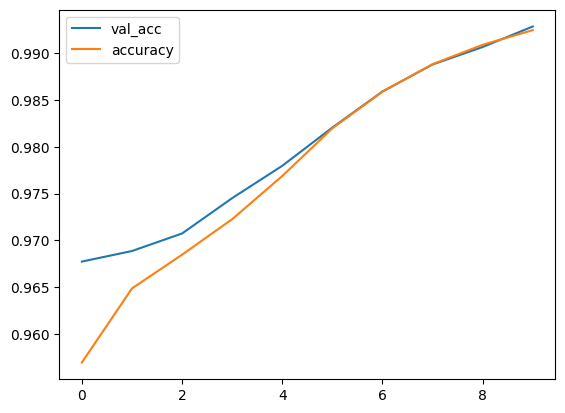

In [34]:
plt.plot(hist.history['val_accuracy'],label='val_acc')
plt.plot(hist.history['accuracy'],label='accuracy')
plt.legend()

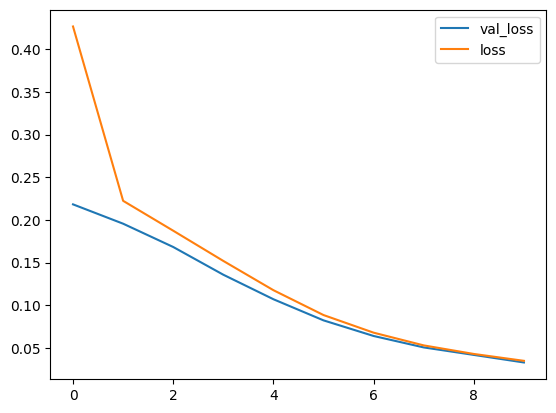

In [35]:
plt.plot(hist.history['val_loss'],label='val_loss')
plt.plot(hist.history['loss'],label='loss')
plt.legend()

In [36]:
encoder_model=Model(encoder_input_placeholder,encoder_states)

In [37]:
decoder_inital_h=Input(shape=(Latent_dim,))
decoder_inital_c=Input(shape=(Latent_dim,))

decoder_initial_states=[decoder_inital_h,decoder_inital_c]

decoder_input_single=Input(shape=(1,))
decoder_embedding_single=decoder_embedding(decoder_input_single)
decoder_outputs_x,h,c=decoder_lstm(decoder_embedding_single,initial_state=decoder_initial_states)

decoder_states=[h,c]

decoder_output=decoder_dense(decoder_outputs_x)

decoder_model=Model([decoder_input_single]  +  decoder_initial_states,
                    [decoder_output]  +  decoder_states
                   )

In [38]:
idx2word_output={v:k for k,v in word2idx_output.items()}

In [39]:
def decode_sequence(sequence):
    states_value=encoder_model.predict(sequence,verbose=0)

    target_seq=np.zeros((1,1))
    target_seq[0,0]=word2idx_output['<sos>']

    eos=word2idx_output['<eos>']

    output_sequence=[]

    for _ in range(max_seq_len):
        output_token,h,c=decoder_model.predict([target_seq]+states_value,verbose=0)

        idx=np.argmax(output_token[0,0,:])

        if idx==eos:
            break

        if idx>0:
            output_sequence.append(idx2word_output[idx])

        target_seq[0,0]=idx
        states_value=[h,c]

    return ' '.join(output_sequence)

In [40]:
i=0
while i<4:
    j=np.random.choice(len(encoder_input))
    input_seq=encoder_input[j:j+1]
    seq=decode_sequence(input_seq)
    print('------------------')
    print('input text:',input_text[j])
    print('real output',translation[j])
    print('predicted output:',seq)
    i+=1

------------------
input text: Basic Indentation
real output इंडेन्टेशन
predicted output: इंडेन्टेशन
------------------
input text: the four of hearts
real output लाल पान का चव्वा
predicted output: लाल पान का चव्वा
------------------
input text: % s index in parent does not match child index
real output अभिभावक में% s सूची शिशु सूची सेमेल नहीं खाती
predicted output: अभिभावक में% s सूची शिशु सूची सेमेल नहीं खाती
------------------
input text: execvp failed
real output execvp विफल
predicted output: execvp विफल


In [ ]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
smoothie = SmoothingFunction().method4

references = []
candidates = []

num_samples = 1000

for i in range(num_samples):
    input_seq = encoder_input[i:i+1]
    predicted_sentence = decode_sequence(input_seq)


    ref = translation[i].strip().split()
    pred = predicted_sentence.strip().split()

    references.append([ref])
    candidates.append(pred)


bleu_score = corpus_bleu(references, candidates, smoothing_function=smoothie)

print("Corpus BLEU score for the model on", num_samples, "samples is:", bleu_score)